## Agentic Rag with LangGraph

In [1]:
import os
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
# from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate

In [2]:
# Initialize model
from langchain_ollama import OllamaLLM
from langchain_community.embeddings import OllamaEmbeddings

llm = OllamaLLM(model="llama3")
embeddings = OllamaEmbeddings(model="llama3",temperature=0)

C:\Users\Rohan\AppData\Local\Temp\ipykernel_7552\3454286214.py:6: LangChainDeprecationWarning: The class `OllamaEmbeddings` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the `langchain-ollama package and should be used instead. To use it run `pip install -U `langchain-ollama` and import as `from `langchain_ollama import OllamaEmbeddings``.
  embeddings = OllamaEmbeddings(model="llama3",temperature=0)


In [3]:
llm

OllamaLLM(model='llama3')

## State Defination

In [4]:
# State: A shared data structure that represents the current snapshot of your application. It can be any data type, but is typically defined using a shared state schema.
# https://docs.langchain.com/oss/python/langgraph/graph-api#state

In [5]:
class AgentState(TypedDict):
    question: str
    needs_retrieval: bool
    documents: List[Document]
    answer: str

In [8]:
### Sample Docuemnt And VectorStore
# Sample documents for demonstration
sample_texts = [
    "LangGraph is a library for building stateful, multi-actor applications with LLMs. It extends LangChain with the ability to coordinate multiple chains across multiple steps of computation in a cyclic manner.",
    "RAG (Retrieval-Augmented Generation) is a technique that combines information retrieval with text generation. It retrieves relevant documents and uses them to provide context for generating more accurate responses.",
    "Vector databases store high-dimensional vectors and enable efficient similarity search. They are commonly used in RAG systems to find relevant documents based on semantic similarity.",
    "Agentic systems are AI systems that can take actions, make decisions, and interact with their environment autonomously. They often use planning and reasoning capabilities."
]

documents=[Document(page_content=text) for text in sample_texts]

##create vector store
vectorstore = FAISS.from_documents(documents, embeddings)
retriever = vectorstore.as_retriever(k=3)

## Agentic function

In [9]:
def decide_retrieval(state: AgentState) -> AgentState:
    """
    Decide if we need to retrieve documents based on the question
    """
    question = state["question"]
    
    # Simple heuristic: if question contains certain keywords, retrieve
    retrieval_keywords = ["what", "how", "explain", "describe", "tell me"]
    needs_retrieval = any(keyword in question.lower() for keyword in retrieval_keywords)
    
    return {**state, "needs_retrieval": needs_retrieval}

In [10]:
def retrieve_documents(state: AgentState) -> AgentState:
    """
    Retrieve relevant documents based on the question
    """
    question = state["question"]
    documents = retriever.invoke(question)
    
    return {**state, "documents": documents}

In [11]:
def generate_answer(state: AgentState) -> AgentState:
    """
    Generate an answer using the retrieved documents or direct response
    """
    question = state["question"]
    documents = state.get("documents", [])
    
    if documents:
        # RAG approach: use documents as context
        context = "\n\n".join([doc.page_content for doc in documents])
        # Create and format the prompt
        prompt_template = ChatPromptTemplate.from_messages([
            ("system", "You are a helpful assistant. Answer the question based on the provided context."),
            ("human", """Context: {context} 
            Question: {question}
            Please provide a clear answer based on the context:""")
        ])
        formatted_prompt = prompt_template.format_messages(context=context, question=question)
    else:
        # Direct response without retrieval
        prompt_template = ChatPromptTemplate.from_messages([
            ("system", "You are a helpful assistant."),
            ("human", "Question: {question}\n\nAnswer:")
        ])
        formatted_prompt = prompt_template.format_messages(question=question)
    
    # Pass the formatted messages to the LLM
    response = llm.invoke(formatted_prompt)
    answer = response.content if hasattr(response, 'content') else str(response)
    
    return {**state, "answer": answer}


## Conditinoal logic

In [12]:
def should_retrieve(state: AgentState) -> str:
    """
    Determine the next step based on retrieval decision
    """
    if state["needs_retrieval"]:
        return "retrieve"
    else:
        return "generate"

## Build the graph

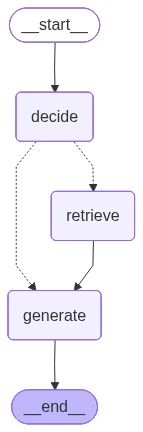

In [13]:
# Create the state graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("decide", decide_retrieval)
workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("generate", generate_answer)

# Set entry point
workflow.set_entry_point("decide")

# Add conditional edges
workflow.add_conditional_edges(
    "decide",
    should_retrieve,
    {
        "retrieve": "retrieve",
        "generate": "generate"
    }
)

# Add edges
workflow.add_edge("retrieve", "generate")
workflow.add_edge("generate", END)

# Compile the graph
app = workflow.compile()
app

## Testing the agentic system

In [14]:
def ask_question(question: str):
    """
    Helper function to ask a question and get an answer
    """
    initial_state = {
        "question": question,
        "documents": [],
        "answer": "",
        "needs_retrieval": False
    }
    
    result = app.invoke(initial_state)
    return result

In [15]:
# Test with a question that should trigger retrieval
question1 = "What is LangGraph?"
result1 = ask_question(question1)
result1

{'question': 'What is LangGraph?',
 'needs_retrieval': True,
 'documents': [Document(id='41ebbb92-0b3a-4cf8-8e88-df1b4ad07c8a', metadata={}, page_content='LangGraph is a library for building stateful, multi-actor applications with LLMs. It extends LangChain with the ability to coordinate multiple chains across multiple steps of computation in a cyclic manner.'),
  Document(id='54cc3e69-4b85-455e-91c0-ebfbe8b53330', metadata={}, page_content='RAG (Retrieval-Augmented Generation) is a technique that combines information retrieval with text generation. It retrieves relevant documents and uses them to provide context for generating more accurate responses.'),
  Document(id='10be667f-ceb7-4df0-9895-85a5bab7e26a', metadata={}, page_content='Vector databases store high-dimensional vectors and enable efficient similarity search. They are commonly used in RAG systems to find relevant documents based on semantic similarity.'),
  Document(id='cf1699e8-942a-4fcc-8edb-da4e1946c2bb', metadata={}, pa

In [16]:
# Test with another question
question2 = "How does RAG work?"
result2 = ask_question(question2)

print(f"Question: {question2}")
print(f"Retrieved documents: {len(result2['documents'])}")
print(f"Answer: {result2['answer']}")
print("\n" + "="*50 + "\n")

Question: How does RAG work?
Retrieved documents: 4
Answer: Based on the provided context, here's how RAG (Retrieval-Augmented Generation) works:

RAG combines information retrieval with text generation. Here's the process:

1. **Information Retrieval**: RAG retrieves relevant documents from a database or corpus that are similar to the input prompt or query.
2. **Context Provision**: The retrieved documents provide context for generating more accurate responses.

By incorporating the relevant documents, RAG systems can generate more informed and precise text outputs compared to traditional generation-only approaches.

Note: Vector databases, like those mentioned in the context, play a crucial role in finding these relevant documents based on semantic similarity.




In [18]:
import sys
print(f"Python: {sys.version}")
print(f"Executable: {sys.executable}")

# Check if in virtual environment
print(f"Virtual env: {sys.prefix != sys.base_prefix}")

Python: 3.13.1 (tags/v3.13.1:0671451, Dec  3 2024, 19:06:28) [MSC v.1942 64 bit (AMD64)]
Executable: d:\Studies\Programming\LangChain\venv\Scripts\python.exe
Virtual env: True
